In [2]:
import os
os.chdir("../")

from data_management.DataManager import CALFData, collateGCN
import numpy as np
import torch 
from Model import ContextAwareModel
from helpers.loss import ContextAwareLoss, SpottingLoss
from modules.train import trainer
import pickle
from dataclasses import dataclass
import matplotlib.pyplot as plt
from modules.Visualiser import collateVisGCN, Visualiser, VisualiseDataset
import seaborn as sns
from helpers.classes import EVENT_DICTIONARY_V2_ALIVE as event_enc
from helpers.classes import get_K_params, loss_weights
import torch.nn as nn

In [3]:
@dataclass
class Args:
    receptive_field = 12
    fps = 5
    chunks_per_epoch = 1824
    class_split = "alive"
    chunk_size = 60
    batch_size = 32
    input_channel = 13
    feature_multiplier=1
    backbone_player = "GCN"
    max_epochs=180
    load_weights=None
    model_name="Testing_Model"
    dim_capsule=16
    lambda_coord=5.0
    lambda_noobj=0.5
    patience=25
    LR=1e-03
    GPU=0 
    max_num_worker=1
    loglevel='INFO'
    annotation_nr = 10
    K_parameters = get_K_params(chunk_size)
    focused_annotation = None
    generate_augmented_data = True
    sgementation_path = None
    freeze_model = True
    generate_artificial_targets = False

In [3]:
args = Args
collate_fn = collateGCN

train_dataset = CALFData(split="train", args=args)
validation_dataset = CALFData(split="validate", args=args)

train_loader = torch.utils.data.DataLoader(train_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

validate_loader = torch.utils.data.DataLoader(validation_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

model = ContextAwareModel(args=args)
criterion = ContextAwareLoss(K=train_dataset.K_parameters, weights=loss_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, 
                            betas=(0.9, 0.999), eps=1e-07, 
                            weight_decay=0, amsgrad=False)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=args.patience)

losses = trainer(train_loader, validate_loader,
                    model, optimizer, scheduler, 
                    criterion,
                    model_name=args.model_name,
                    max_epochs=args.max_epochs, 
                    save_dir=f"models/weighted_loss.pth.tar")

del train_dataset, validation_dataset, train_loader, validate_loader

with open(f'results/weighted_loss.pkl', 'wb') as file:
    pickle.dump(losses, file)

Get labels & features: 100%|██████████| 8/8 [02:16<00:00, 17.03s/it]
Train 1: Time 6.017s (it:5.108s) Data:1.134s (it:1.063s) Loss 1.4416e+02 : 100%|████████████████████████████████████████████████| 57/57 [05:42<00:00,  6.02s/it]
Evaluate 1: Time 3.140s (it:4.186s) Data:0.937s (it:0.747s) Loss 1.6698e+02 : 100%|█████████████████████████████████████████████| 57/57 [02:58<00:00,  3.14s/it]
Train 2: Time 5.983s (it:5.852s) Data:1.146s (it:1.003s) Loss 1.3236e+02 : 100%|████████████████████████████████████████████████| 57/57 [05:41<00:00,  5.98s/it]
Evaluate 2: Time 2.849s (it:2.432s) Data:0.862s (it:0.733s) Loss 1.2806e+02 : 100%|█████████████████████████████████████████████| 57/57 [02:42<00:00,  2.85s/it]
Train 3: Time 5.821s (it:5.074s) Data:1.149s (it:1.044s) Loss 1.2534e+02 : 100%|████████████████████████████████████████████████| 57/57 [05:31<00:00,  5.82s/it]
Evaluate 3: Time 2.885s (it:2.457s) Data:0.870s (it:0.749s) Loss 1.0799e+02 : 100%|███████████████████████████████████████████

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.92s/it]


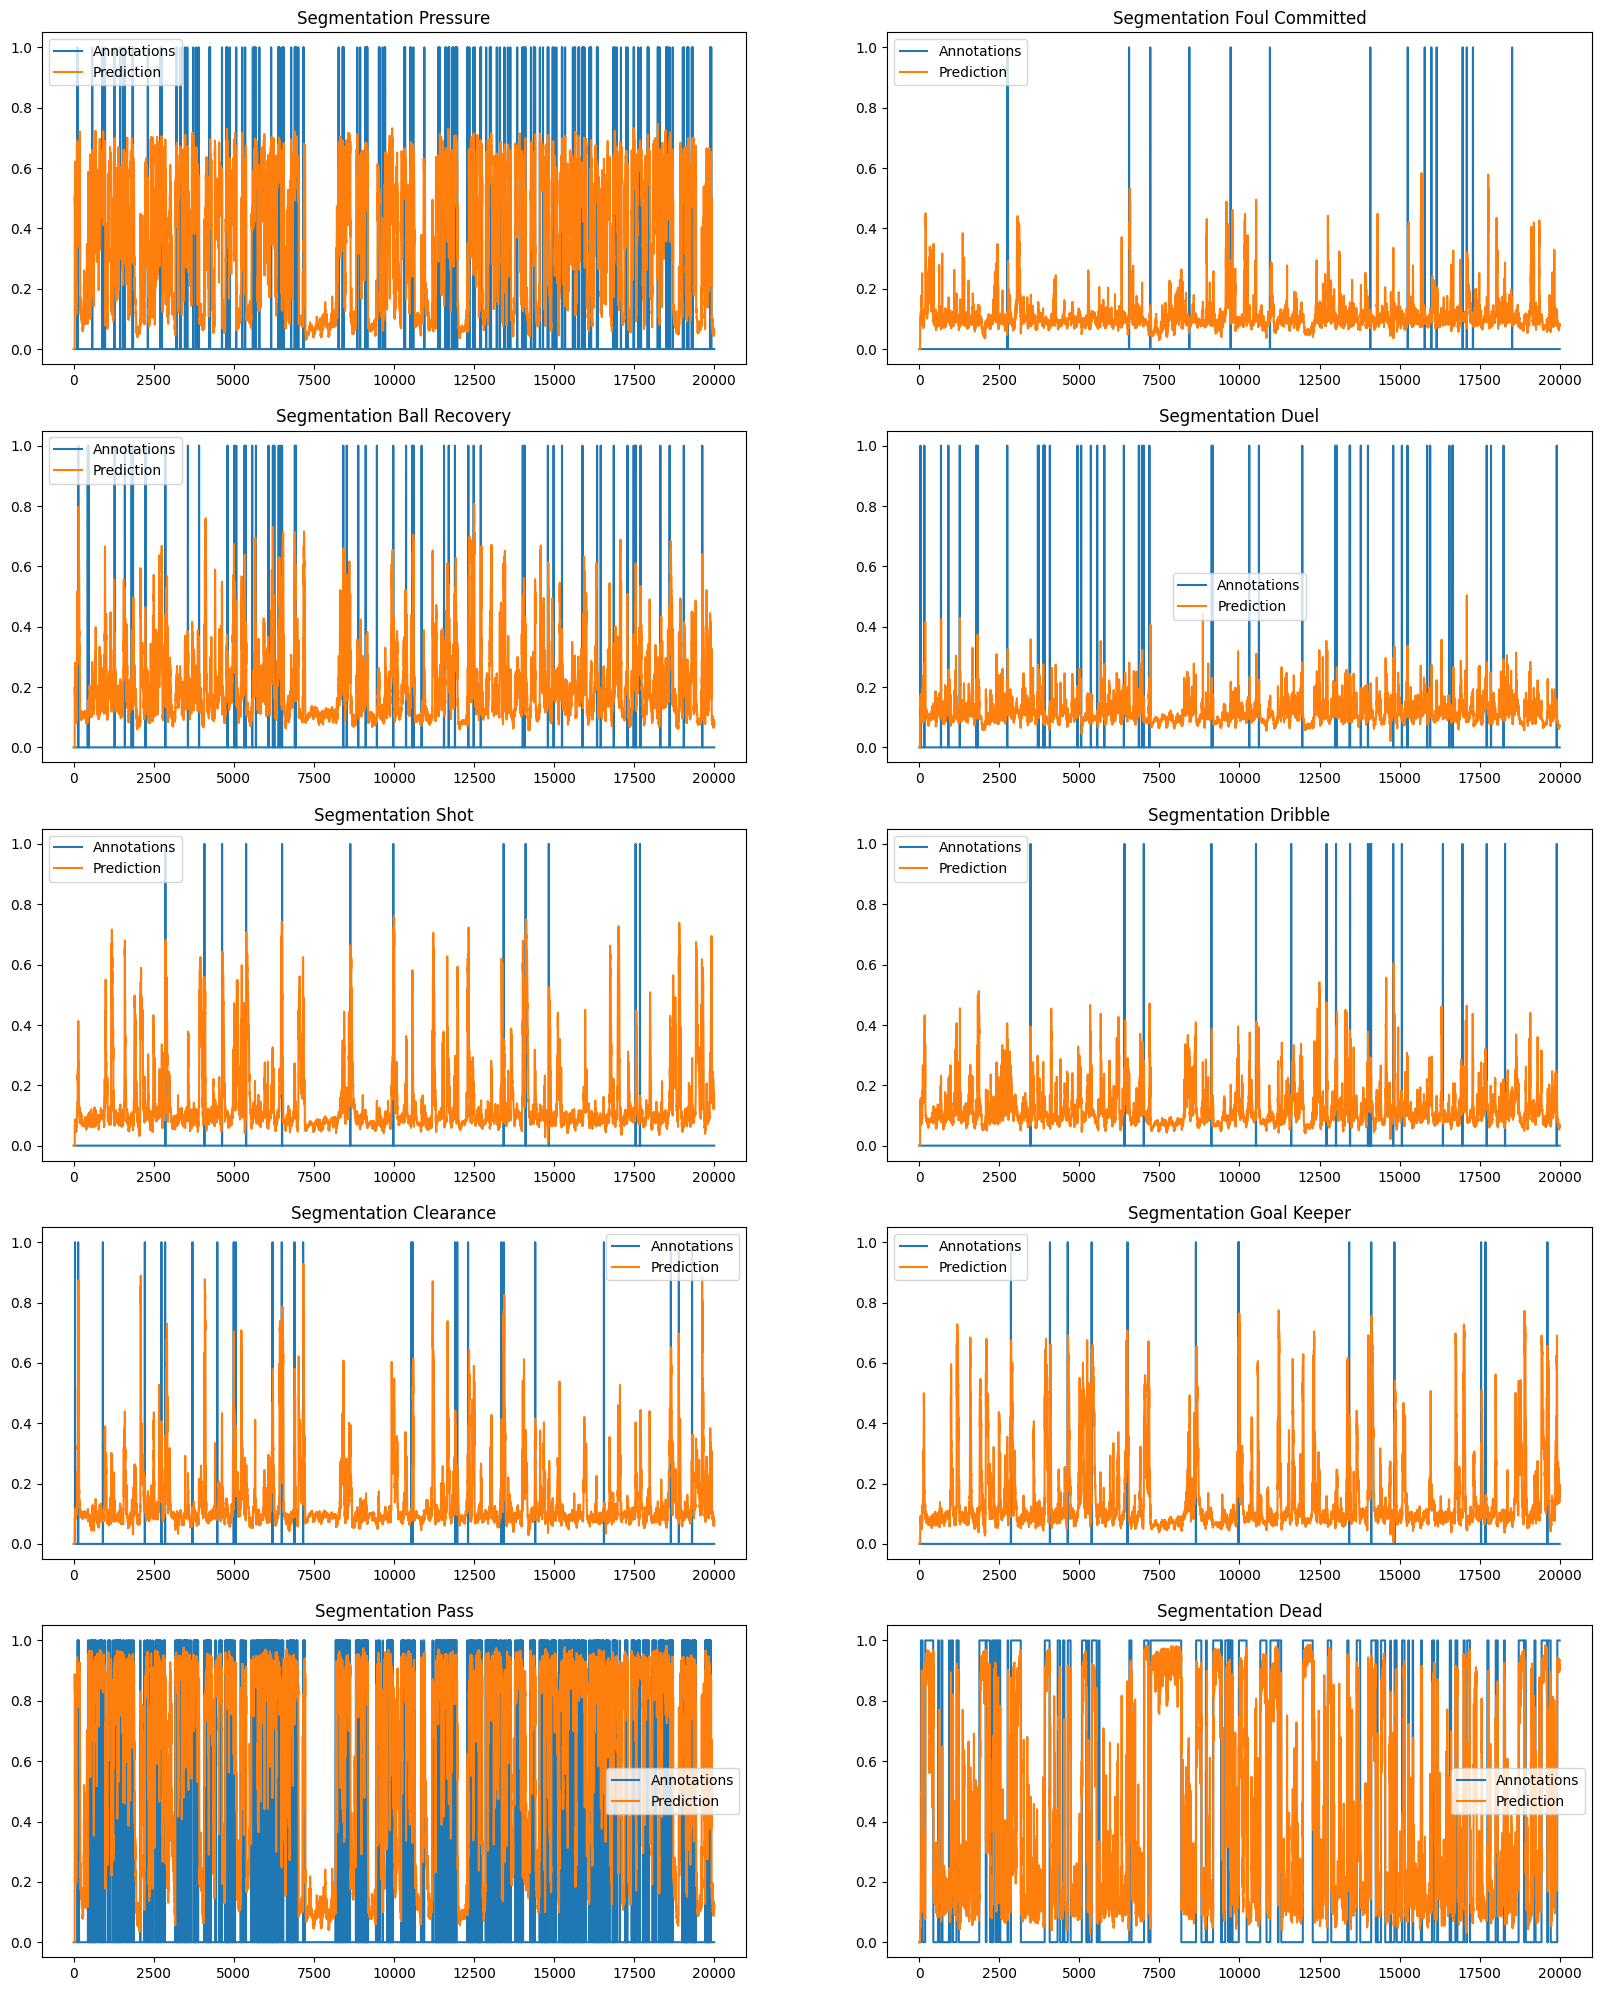

(<Figure size 2000x2500 with 10 Axes>,
 array([[<Axes: title={'center': 'Segmentation Pressure'}>,
         <Axes: title={'center': 'Segmentation Foul Committed'}>],
        [<Axes: title={'center': 'Segmentation Ball Recovery'}>,
         <Axes: title={'center': 'Segmentation Duel'}>],
        [<Axes: title={'center': 'Segmentation Shot'}>,
         <Axes: title={'center': 'Segmentation Dribble'}>],
        [<Axes: title={'center': 'Segmentation Clearance'}>,
         <Axes: title={'center': 'Segmentation Goal Keeper'}>],
        [<Axes: title={'center': 'Segmentation Pass'}>,
         <Axes: title={'center': 'Segmentation Dead'}>]], dtype=object))

In [5]:

args = Args
chunk_size = 60
receptive_field = 0.2 * chunk_size
args.K_parameters = get_K_params(chunk_size)
args.chunk_size = chunk_size
args.receptive_field = receptive_field
collate_fn = collateVisGCN
model_path = f"models/weighted_loss.pth.tar"
model = torch.load(model_path)
visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True)
visualiser.plot_predictions(frame_threshold=20000, save_dir=None, annotation=None)

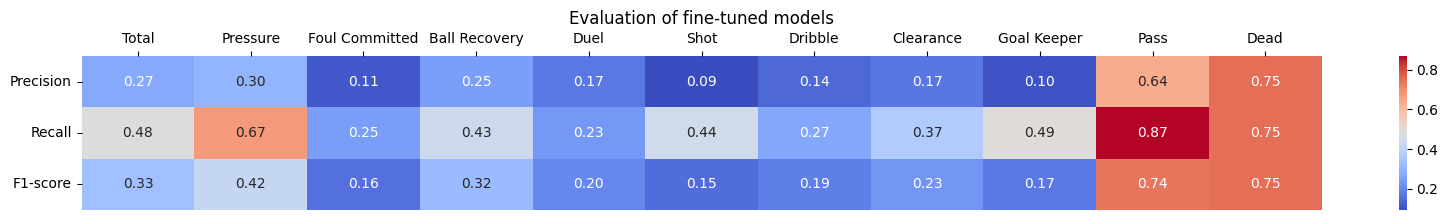

In [14]:
precision, recall, f1_score, _ = visualiser.norm_evaluation_segmentation()
precision = np.concatenate((np.array([np.mean(precision)]), precision))
recall = np.concatenate((np.array([np.mean(recall)]), recall))
f1_score = np.concatenate((np.array([np.mean(f1_score)]), f1_score))

cols = ["Total"] + list(event_enc.keys())
rows = ["Precision", "Recall", "F1-score"]

fig = plt.figure(figsize=(20, 2))

total_scores = np.concatenate((precision, recall, f1_score))
# ax1.set_title("Precision scores")
ax = sns.heatmap(total_scores.reshape(3,-1), annot=True, cmap="coolwarm", fmt=".2f", xticklabels=True, yticklabels=True)
ax.set_xticklabels(cols, rotation=0)
ax.xaxis.tick_top()
ax.set_yticklabels(rows, rotation=0)

plt.title("Evaluation of fine-tuned models")
plt.show()

In [11]:
total_scores.shape

(40,)

In [15]:
model

ContextAwareModel(
  (r_conv_1): GCNConv(13, 16)
  (r_conv_2): GCNConv(16, 32)
  (r_conv_3): GCNConv(32, 64)
  (r_conv_4): GCNConv(64, 152)
  (pad_seg): ZeroPad2d((0, 0, 1, 1))
  (conv_seg): Conv2d(152, 160, kernel_size=(3, 1), stride=(1, 1))
  (batch_seg): BatchNorm2d(300, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
)

In [16]:
from data_management.FileFinder import find_files

listGames = find_files("../football_games")

In [21]:
listGames[0]

MatchFile(datafile='../football_games/WC2018/BEL-BRA/108602_TracDAT/108602.dat', metafile='../football_games/WC2018/BEL-BRA/108602_TracDAT/108602_metadata.xml', annotatedfile='../football_games/WC2018/BEL-BRA/108602_TracDAT/annotation.npz', name='BEL-BRA', home='BEL', away='BRA', index=None)